# Setup enviorment

In [1]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

2023-06-07 20:39:28.126870: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-07 20:39:28.166310: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-07 20:39:28.167450: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 20:39:29.016707: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


In [2]:
""" Read Dataset:"""

embeddings = None
temp_prec = ['../Tabular_data/precipitation_all.csv', '../Tabular_data/temperature_all 2.csv']
static = '../Tabular_data/dengue_tabular.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv('Embeddings/MobileNetV2_224_1024.csv')['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 3
autoregressive = False
feature_range = (-1, 1)
n_tests=10

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [3]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality, temp_prec=temp_prec, static=static) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [4]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 29)
The test shape is: (33, 29)
The train shape is: (130, 29)
The test shape is: (33, 29)
The train shape is: (130, 29)
The test shape is: (33, 29)
The train shape is: (130, 29)
The test shape is: (33, 29)
The train shape is: (130, 29)
The test shape is: (33, 29)
The train shape is: (130, 29)
The test shape is: (33, 29)
The train shape is: (130, 29)
The test shape is: (33, 29)
The train shape is: (130, 29)
The test shape is: (33, 29)
The train shape is: (130, 29)
The test shape is: (33, 29)
The train shape is: (130, 29)
The test shape is: (33, 29)


### Normalize features

In [5]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [6]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

temperature  precipitation  Age0-4(%)  Age5-14(%)  Age15-29(%)  \
41001 201546    -0.214918       0.717409   1.026036    0.571173    -0.482649   
      201547    -0.699029      -0.201813   1.026036    0.571173    -0.482649   
      201548     0.476415       0.142851   1.026036    0.571173    -0.482649   
      201549     1.031855      -0.733771   1.026036    0.571173    -0.482649   
      201550     0.636574       0.782050   1.026036    0.571173    -0.482649   

              Age>30(%)  AfrocolombianPopulation(%)  IndianPopulation(%)  \
41001 201546    -0.5755                   -0.550876             0.102858   
      201547    -0.5755                   -0.550876             0.102858   
      201548    -0.5755                   -0.550876             0.102858   
      201549    -0.5755                   -0.550876             0.102858   
      201550    -0.5755                   -0.550876             0.102858   

              PeoplewithDisabilities(%)  Peoplewhocannotreadorwrite(%)  ...  \
41001 201546                    0.68862                       0.557852  ...   
      201547                    0.68862                       0.557852  ...   
      201548                    0.68862                       0.557852  ...   
      201549                    0.68862                       0.557852  ...   
      201550                    0.68862                       0.557852  ...   

              Buildingstratification1(%)  Buildingstratification2(%)  \
41001 201546                   -0.049236                    1.299709   
      201547                   -0.049236                    1.299709   
      201548                   -0.049236                    1.299709   
      201549                   -0.049236                    1.299709   
      201550                   -0.049236                    1.299709   

              Buildingstratification3(%)  Buildingstratification4(%)  \
41001 201546                   -1.218603                   -0.616395   
      201547                   -1.218603                   -0.616395   
      201548                   -1.218603                   -0.616395   
      201549                   -1.218603                   -0.616395   
      201550                   -1.218603                   -0.616395   

              Buildingstratification5(%)  Buildingstratification6(%)  \
41001 201546                    -0.69223                   -0.912227   
      201547                    -0.69223                   -0.912227   
      201548                    -0.69223                   -0.912227   
      201549                    -0.69223                   -0.912227   
      201550                    -0.69223                   -0.912227   

              NumberofhospitalsperKm2  NumberofhousesperKm2  population  \
41001 201546                -0.835433              -0.74019   -0.773497   
      201547                -0.835433              -0.74019   -0.773497   
      201548                -0.835433              -0.74019   -0.773497   
      201549                -0.835433              -0.74019   -0.773497   
      201550                -0.835433              -0.74019   -0.773497   

                Labels  
41001 201546  0.064361  
      201547  0.091926  
      201548  0.082738  
      201549  0.082738  
      201550  0.211376  

[5 rows x 29 columns]

In [7]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

temperature  precipitation  Age0-4(%)  Age5-14(%)  Age15-29(%)  \
41001 201820    -0.879642      -0.063182   1.026036    0.571173    -0.482649   
      201821    -0.495573       0.091043   1.026036    0.571173    -0.482649   
      201822    -1.183651      -0.006134   1.026036    0.571173    -0.482649   
      201823    -1.271677      -0.732817   1.026036    0.571173    -0.482649   
      201824    -0.804984      -0.624895   1.026036    0.571173    -0.482649   

              Age>30(%)  AfrocolombianPopulation(%)  IndianPopulation(%)  \
41001 201820    -0.5755                   -0.550876             0.102858   
      201821    -0.5755                   -0.550876             0.102858   
      201822    -0.5755                   -0.550876             0.102858   
      201823    -0.5755                   -0.550876             0.102858   
      201824    -0.5755                   -0.550876             0.102858   

              PeoplewithDisabilities(%)  Peoplewhocannotreadorwrite(%)  ...  \
41001 201820                    0.68862                       0.557852  ...   
      201821                    0.68862                       0.557852  ...   
      201822                    0.68862                       0.557852  ...   
      201823                    0.68862                       0.557852  ...   
      201824                    0.68862                       0.557852  ...   

              Buildingstratification1(%)  Buildingstratification2(%)  \
41001 201820                   -0.049236                    1.299709   
      201821                   -0.049236                    1.299709   
      201822                   -0.049236                    1.299709   
      201823                   -0.049236                    1.299709   
      201824                   -0.049236                    1.299709   

              Buildingstratification3(%)  Buildingstratification4(%)  \
41001 201820                   -1.218603                   -0.616395   
      201821                   -1.218603                   -0.616395   
      201822                   -1.218603                   -0.616395   
      201823                   -1.218603                   -0.616395   
      201824                   -1.218603                   -0.616395   

              Buildingstratification5(%)  Buildingstratification6(%)  \
41001 201820                    -0.69223                   -0.912227   
      201821                    -0.69223                   -0.912227   
      201822                    -0.69223                   -0.912227   
      201823                    -0.69223                   -0.912227   
      201824                    -0.69223                   -0.912227   

              NumberofhospitalsperKm2  NumberofhousesperKm2  population  \
41001 201820                -0.835433              -0.74019   -0.773497   
      201821                -0.835433              -0.74019   -0.773497   
      201822                -0.835433              -0.74019   -0.773497   
      201823                -0.835433              -0.74019   -0.773497   
      201824                -0.835433              -0.74019   -0.773497   

                Labels  
41001 201820 -0.275610  
      201821 -0.321552  
      201822 -0.238856  
      201823 -0.321552  
      201824 -0.293986  

[5 rows x 29 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [8]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(128, 85)

### Merge train data

In [9]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [10]:
train.shape

(1280, 85)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1280, 84)
The shape of the labels is (1280, 1)
Test:
The shape of the features is (310, 84)
The shape of the labels is (310, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

The initial shapes are:
The train shape is (1280, 84)
The test shape is (310, 84)
-----------------------
The Final shapes are:
The train shape is (1280, 3, 28)
The test shape is (310, 3, 28)


# 2. Model

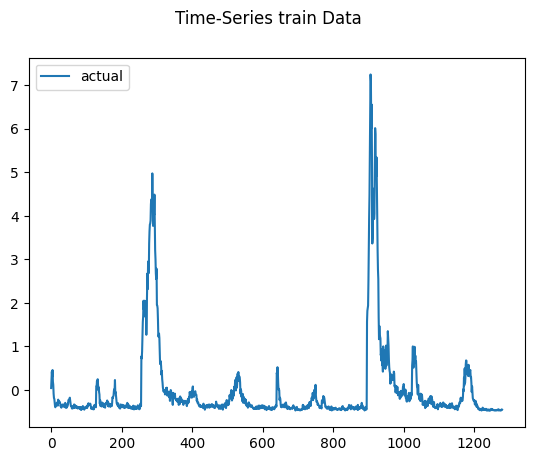

2023-06-07 20:39:34.799785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 20:39:34.801331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 20:39:34.802461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Restoring model weights from the end of the best epoch: 3.
Epoch 11: early stopping


2023-06-07 20:39:56.053910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 20:39:56.055603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 20:39:56.056833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 1s 10ms/step
Test MAE: 31.639
Test RMSE: 37.149
Test sMAPE: 87.766
Test R Squared: -0.391
{'mae': 31.63921905025359, 'rmse': 37.14942567820689, 'smape': 87.7658569164453, 'r2': -0.3910384756514991}


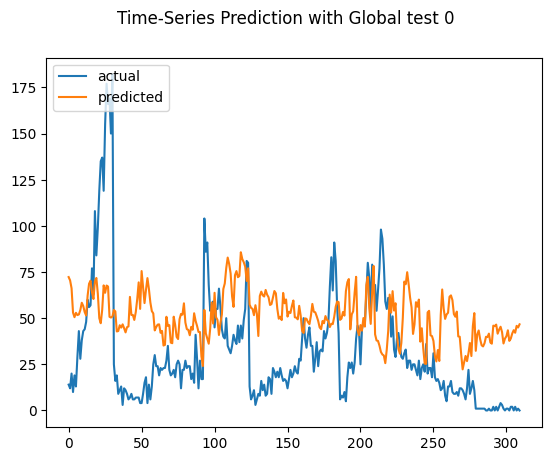

2023-06-07 20:39:57.312207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 20:39:57.314057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 20:39:57.315329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Restoring model weights from the end of the best epoch: 5.
Epoch 13: early stopping


2023-06-07 20:40:21.215806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 20:40:21.217336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 20:40:21.218640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 1s 10ms/step
Test MAE: 32.154
Test RMSE: 37.512
Test sMAPE: 88.665
Test R Squared: -0.418
{'mae': 32.154022590431474, 'rmse': 37.511922159972464, 'smape': 88.66452344066452, 'r2': -0.41831785946073086}


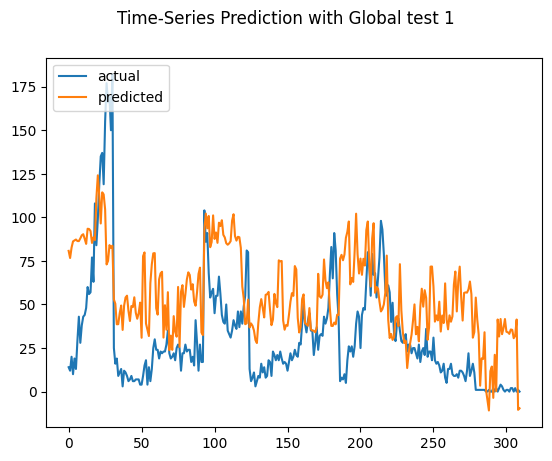

2023-06-07 20:40:22.475101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 20:40:22.476792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 20:40:22.477955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping


2023-06-07 20:40:40.515359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 20:40:40.517032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 20:40:40.518216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 1s 10ms/step
Test MAE: 21.650
Test RMSE: 31.359
Test sMAPE: 73.562
Test R Squared: 0.009
{'mae': 21.650035390546243, 'rmse': 31.359435157280963, 'smape': 73.56170265507824, 'r2': 0.008776938330067985}


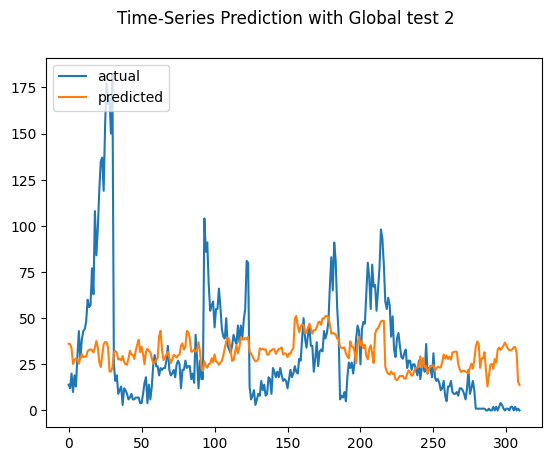

2023-06-07 20:40:41.777638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 20:40:41.779423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 20:40:41.780594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping


2023-06-07 20:40:59.605788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 20:40:59.607533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 20:40:59.608712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 1s 10ms/step
Test MAE: 27.649
Test RMSE: 34.086
Test sMAPE: 82.039
Test R Squared: -0.171
{'mae': 27.648727816920125, 'rmse': 34.085806100151565, 'smape': 82.03889895622594, 'r2': -0.17106788932420214}


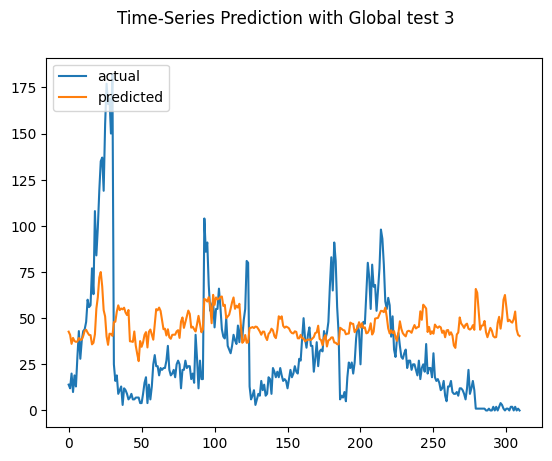

2023-06-07 20:41:00.833317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 20:41:00.835060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 20:41:00.836221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping


2023-06-07 20:41:19.131298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 20:41:19.133032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 20:41:19.134355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 1s 10ms/step
Test MAE: 29.475
Test RMSE: 38.067
Test sMAPE: 84.327
Test R Squared: -0.461
{'mae': 29.474993551931075, 'rmse': 38.06652498410005, 'smape': 84.32652543875483, 'r2': -0.46056671760127177}


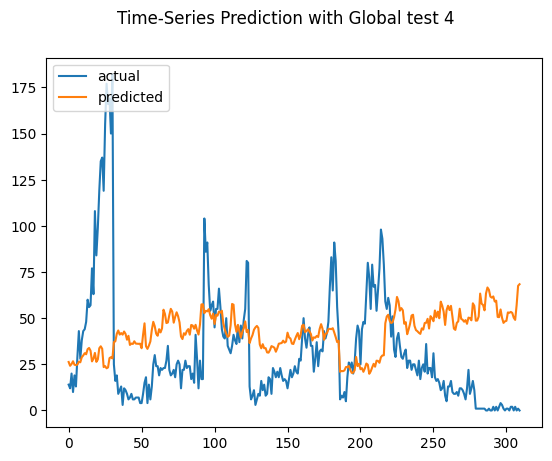

2023-06-07 20:41:20.373689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 20:41:20.375516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 20:41:20.376716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping


2023-06-07 20:41:38.267573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 20:41:38.269221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 20:41:38.270456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 1s 10ms/step
Test MAE: 25.032
Test RMSE: 37.178
Test sMAPE: 93.017
Test R Squared: -0.393
{'mae': 25.03163334453298, 'rmse': 37.17750286961512, 'smape': 93.01742760402993, 'r2': -0.3931419381991148}


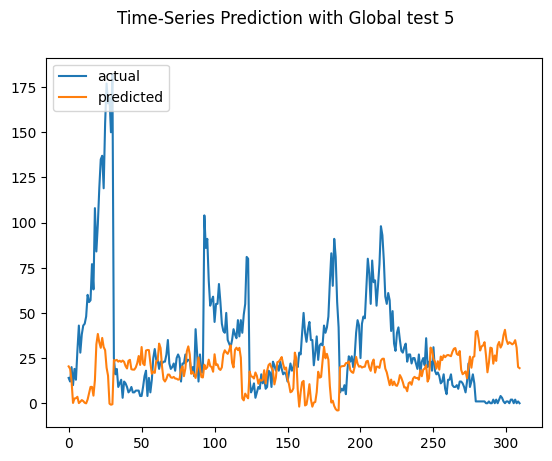

2023-06-07 20:41:39.515017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 20:41:39.516661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 20:41:39.517819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Restoring model weights from the end of the best epoch: 2.
Epoch 10: early stopping


2023-06-07 20:41:59.451086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 20:41:59.452986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 20:41:59.454302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 1s 10ms/step
Test MAE: 30.545
Test RMSE: 36.243
Test sMAPE: 86.929
Test R Squared: -0.324
{'mae': 30.545404846437517, 'rmse': 36.2431893084347, 'smape': 86.9292002992689, 'r2': -0.32399928167545977}


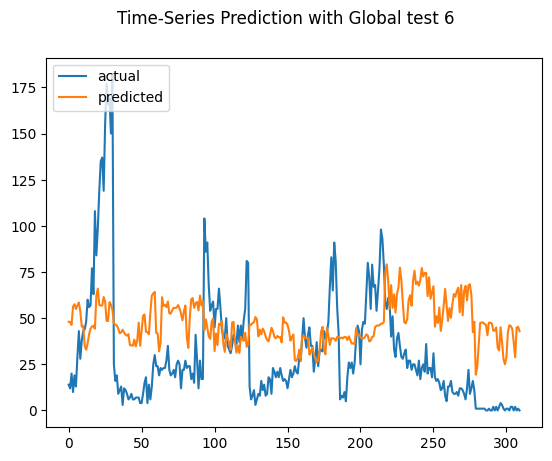

2023-06-07 20:42:00.703127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 20:42:00.704808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 20:42:00.705984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Restoring model weights from the end of the best epoch: 4.
Epoch 12: early stopping


2023-06-07 20:42:23.480677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 20:42:23.482264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 20:42:23.483482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 1s 11ms/step
Test MAE: 26.164
Test RMSE: 33.001
Test sMAPE: 80.051
Test R Squared: -0.098
{'mae': 26.16356738305861, 'rmse': 33.00105703075184, 'smape': 80.05101469489874, 'r2': -0.0977176211186197}


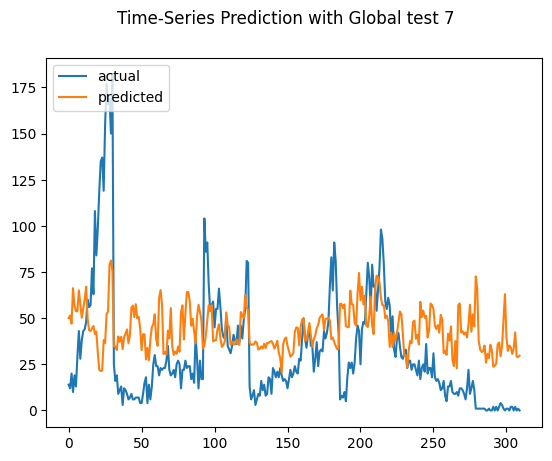

2023-06-07 20:42:24.719820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 20:42:24.721417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 20:42:24.722647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Restoring model weights from the end of the best epoch: 6.
Epoch 14: early stopping


2023-06-07 20:42:50.225891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 20:42:50.227658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 20:42:50.228887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 1s 10ms/step
Test MAE: 32.698
Test RMSE: 38.860
Test sMAPE: 97.887
Test R Squared: -0.522
{'mae': 32.69766864065201, 'rmse': 38.85987349917945, 'smape': 97.88683518079371, 'r2': -0.522080771372331}


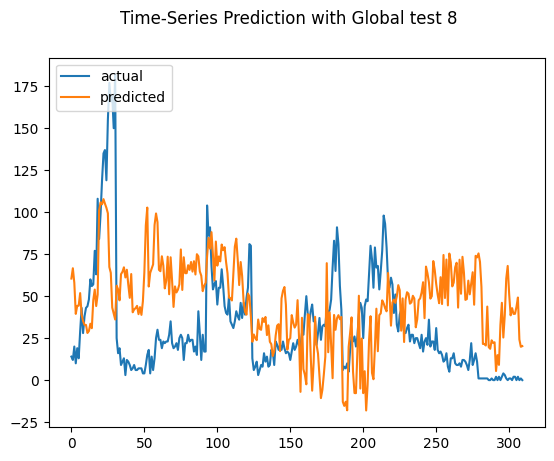

2023-06-07 20:42:51.902218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 20:42:51.905011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 20:42:51.907501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping


2023-06-07 20:43:09.972332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 20:43:09.973974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 20:43:09.975117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 1s 10ms/step
Test MAE: 37.464
Test RMSE: 45.404
Test sMAPE: 93.151
Test R Squared: -1.078
{'mae': 37.46394248470183, 'rmse': 45.403943152137735, 'smape': 93.15125865948278, 'r2': -1.0778877224307144}


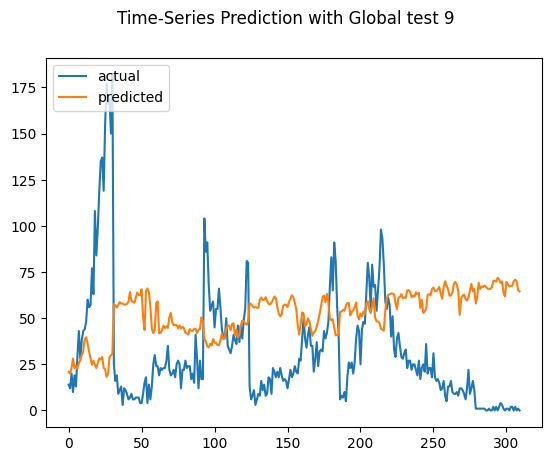

rmse : average=36.886, std=3.637
mae : average=29.447, std=4.272
smape : average=86.739, std=6.752
r2 : average=-0.385, std=0.282


([36.88586799398308, 3.637049752972135],
 [29.44692150994654, 4.271792577893673],
 [86.73932438456428, 6.751958903535782],
 [-0.3847041338503876, 0.28158236793379615])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=n_tests, plot_samples=True, Municipality='Global')